In [7]:
from pyspark import SparkConf, SparkContext

In [8]:
conf = SparkConf().setMaster("local[*]").setAppName("Kmeans")
sc = SparkContext(conf=conf)

In [53]:
data = sc.textFile("data.txt").map(lambda line: line.split("\t"))

In [54]:
data1 = sc.parallelize(list(enumerate(data.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [55]:
c1 = sc.textFile("c1.txt").map(lambda line: line.split("\t"))

In [56]:
c11 = sc.parallelize(list(enumerate(c1.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [57]:
c2 = sc.textFile("c2.txt").map(lambda line: line.split("\t"))

In [58]:
c21 = sc.parallelize(list(enumerate(c2.collect()))).map(lambda x: (x[0],x[1][0].split(" ")))

In [59]:
dict_data = {}
dict_data.update(data1.collect())

In [192]:
dict_c1 = {}
dict_c1.update(c11.collect())

In [193]:
dict_c2 = {}
dict_c2.update(c21.collect())

# 0. 總共跑4次差不多的過程，由上而下(1)-(4)分別是Euclidean與C1、Euclidean與C2、Manhattan與C1、Manhattan與C2

# Euclidean Distance

# (1)C1

# 1.mapper1:算出離最近的cluster的距離，並儲存其編號

In [194]:
def mapper1(x):
    all_dis = []
    #有幾個dimension就要跑幾次
    for i in range(len(dict_c1)):
        distance = 0
        #和每個center做比較
        for c in range(len(dict_c1[0])):
            distance += (eval(x[1][c])-eval(dict_c1[i][c])) ** 2
        #將與這10個center的距離list起來
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1])) #後面那一項選list裡面distance最小的(i,distance)

In [195]:
data2 = data1.map(mapper1)

# 2.只需將所有distance相加就可得到cost_function

In [196]:
cost_function = data2.map(lambda x: x[1]).values().sum()

In [197]:
cost_list1 = []

In [198]:
cost_list1.append(cost_function)

# 3.算出新的center
+ distribute: return ("最近距離中心"的編號，座標編號)
+ cluster: groupbykey之後 return (中心編號，"被分類到此中心的所有座標"的編號)
+ mapper2: 對於每個中心，把"被分類到此中心的所有座標"取平均得到一個新的中心

In [199]:
distribute = data2.map(lambda x: (x[1][0],x[0]))

In [200]:
cluster = distribute.groupByKey()

In [201]:
def mapper2(x):
    list4 = []
    amount = len(x[1])
    #有幾個dimension
    for i in range(len(dict_data[0])):
        sum2 = 0
        #每一個被分配到此中心的座標
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        #每次append新中心的1個dimension
        list4.append(sum2/amount)      
    return (x[0],list4) #list4最後會是新中心的座標

In [202]:
new_center = cluster.map(mapper2)

In [203]:
dict_c1.update(new_center.collect())

# 4.再跑19次

In [204]:
def mapper3(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += (eval(x[1][c])-dict_c1[i][c]) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [205]:
for i in range(19):
    data2 = data1.map(mapper3)
    
    #cost_function
    cost_function = data2.map(lambda x: x[1]).values().sum()
    cost_list1.append(cost_function)
    
    #new_center
    distribute = data2.map(lambda x: (x[1][0],x[0]))
    cluster = distribute.groupByKey()
    new_center = cluster.map(mapper2)
    dict_c1.update(new_center.collect())

In [74]:
cost_list1

[623660345.3064113,
 509862908.2975454,
 485480681.8720078,
 463997011.685013,
 460969266.5729963,
 460537847.98276776,
 460313099.6535457,
 460003523.88940746,
 459570539.3177351,
 459021103.3422907,
 458490656.191981,
 457944232.5879743,
 457558005.1986762,
 457290136.35230225,
 457050555.0595627,
 456892235.61535454,
 456703630.7370334,
 456404203.01897496,
 456177800.5419933,
 455986871.0273458]

# 5.計算percentage_improvement

In [206]:
percentage_improvement_c1_e = abs(cost_list1[-1]-cost_list1[0])/cost_list1[0] 

In [207]:
percentage_improvement_c1_e

0.26885383292517284

In [208]:
list_data = list(new_center.collect())

In [209]:
list_data.sort()

# 6.算出中心點之間的Euclidean Distances和Manhattan Distances

In [210]:
def mapper4(x):
    list4 = []
    list5 = []
    for c in list_data:
        if c[0] <= x[0]:
            list4.append(0.0)
            list5.append(0.0)
        else:
            sum_4 = 0
            sum_5 = 0
            for k in range(len(x[1])):
                sum_4 += (x[1][k]-c[1][k]) ** 2
                sum_5 += abs(x[1][k]-c[1][k])
            list4.append(sum_4 ** (1/2))
            list5.append(sum_5)
    return (x[0],list4,list5)

In [226]:
new_center_list = new_center.map(mapper4)

In [227]:
ec1 = list(new_center_list.collect())

In [228]:
ec1

[(8,
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 975.3204225971708],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1327.5839795031056]),
 (0,
  [0.0,
   692.1578865536187,
   3490.2586403239793,
   205.75027883457204,
   346.71882253414816,
   512.6122467083617,
   444.7310005470825,
   566.2019922936282,
   1282.7708445154385,
   307.66912835221507],
  [0.0,
   728.9243139995409,
   3797.8990780180675,
   212.18109038688195,
   374.8904224625678,
   577.4020758222025,
   499.1578939470968,
   645.7697774866793,
   1731.0643066429416,
   406.70122510554586]),
 (9,
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 (1,
  [0.0,
   0.0,
   2798.8010531589434,
   897.6589863450828,
   1038.8268882911389,
   1204.0781989863117,
   1136.3273438149283,
   1257.4495275592424,
   669.8902282318555,
   412.076077167744],
  [0.0,
   0.0,
   3072.8886904466503,
   935.8853379058191,
   1100.833091013825,
   1303.8957233218873,
   122

# (2)C2

In [229]:
def mapper1_1(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += (eval(x[1][c])-eval(dict_c2[i][c])) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [230]:
data2_1 = data1.map(mapper1_1)

# cost_function_C2

In [231]:
cost_function_1 = data2_1.map(lambda x: x[1]).values().sum()

In [232]:
cost_list1_1 = []

In [233]:
cost_list1_1.append(cost_function_1)

# new_center_C2

In [234]:
distribute_1 = data2_1.map(lambda x: (x[1][0],x[0]))

In [235]:
cluster_1 = distribute_1.groupByKey()

In [236]:
def mapper2_1(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [237]:
new_center_1 = cluster_1.map(mapper2_1)

In [238]:
dict_c2.update(new_center_1.collect())

# iteration

In [239]:
def mapper3_1(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += (eval(x[1][c])-dict_c2[i][c]) ** 2
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [240]:
for i in range(19):
    data2_1 = data1.map(mapper3_1)
    
    #cost_function
    cost_function_1 = data2_1.map(lambda x: x[1]).values().sum()
    cost_list1_1.append(cost_function_1)
    
    #new_center
    distribute_1 = data2_1.map(lambda x: (x[1][0],x[0]))
    cluster_1 = distribute_1.groupByKey()
    new_center_1 = cluster_1.map(mapper2_1)
    dict_c2.update(new_center_1.collect())

# iteration=20 

In [241]:
percentage_improvement_c2_e = abs(cost_list1_1[-1]-cost_list1_1[0])/cost_list1_1[0] 

In [242]:
percentage_improvement_c2_e

0.79437750291599

In [243]:
list_data_1 = list(new_center_1.collect())

In [244]:
list_data_1.sort()

In [245]:
def mapper4_1(x):
    list4 = []
    list5 = []
    for c in list_data_1:
        if c[0] <= x[0]:
            list4.append(0.0)
            list5.append(0.0)
        else:
            sum_4 = 0
            sum_5 = 0
            for k in range(len(x[1])):
                sum_4 += (x[1][k]-c[1][k]) ** 2
                sum_5 += abs(x[1][k]-c[1][k])
            list4.append(sum_4 ** (1/2))
            list5.append(sum_5)
    return (x[0],list4,list5)

In [246]:
new_center_list_1 = new_center_1.map(mapper4_1)

In [290]:
ec2 = list(new_center_list_1.collect())

# MA_DISTANCE

# (3)C1

In [248]:
dict_c1 = {}
dict_c1.update(c11.collect())

In [249]:
def mapper1_2(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += abs(eval(x[1][c])-eval(dict_c1[i][c]))
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [250]:
data2_2 = data1.map(mapper1_2)

# cost_function_C2

In [251]:
cost_function_2 = data2_2.map(lambda x: x[1]).values().sum()

In [252]:
cost_list1_2 = []

In [253]:
cost_list1_2.append(cost_function_2)

# new_center_C2

In [254]:
distribute_2 = data2_2.map(lambda x: (x[1][0],x[0]))

In [255]:
cluster_2 = distribute_2.groupByKey()

In [256]:
def mapper2_2(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [257]:
new_center_2 = cluster_2.map(mapper2_2)

In [258]:
dict_c1.update(new_center_2.collect())

# iteration

In [259]:
def mapper3_2(x):
    all_dis = []
    for i in range(len(dict_c1)):
        distance = 0
        for c in range(len(dict_c1[0])):
            distance += abs(eval(x[1][c])-dict_c1[i][c])
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [260]:
for i in range(19):
    data2_2 = data1.map(mapper3_2)
    
    #cost_function
    cost_function_2 = data2_2.map(lambda x: x[1]).values().sum()
    cost_list1_2.append(cost_function_2)
    
    #new_center
    distribute_2 = data2_2.map(lambda x: (x[1][0],x[0]))
    cluster_2 = distribute_2.groupByKey()
    new_center_2 = cluster_2.map(mapper2_2)
    dict_c1.update(new_center_2.collect())

# iteration=20 

In [261]:
percentage_improvement_c1_m = abs(cost_list1_2[-1]-cost_list1_2[0])/cost_list1_2[0] 

In [127]:
percentage_improvement_c1_m

0.18378954327236927

In [262]:
list_data_2 = list(new_center_2.collect())

In [263]:
list_data_2.sort()

In [264]:
def mapper4_2(x):
    list4 = []
    list5 = []
    for c in list_data_2:
        if c[0] <= x[0]:
            list4.append(0.0)
            list5.append(0.0)
        else:
            sum_4 = 0
            sum_5 = 0
            for k in range(len(x[1])):
                sum_4 += (x[1][k]-c[1][k]) ** 2
                sum_5 += abs(x[1][k]-c[1][k])
            list4.append(sum_4 ** (1/2))
            list5.append(sum_5)
    return (x[0],list4,list5)

In [265]:
new_center_list_2 = new_center_2.map(mapper4_2)

In [289]:
mc1 = list(new_center_list_2.collect())

# (4)C2

In [267]:
dict_c2 = {}
dict_c2.update(c21.collect())

In [268]:
def mapper1_3(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += abs(eval(x[1][c])-eval(dict_c2[i][c]))
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [269]:
data2_3 = data1.map(mapper1_3)

# cost_function_C2

In [270]:
cost_function_3 = data2_3.map(lambda x: x[1]).values().sum()

In [271]:
cost_list1_3 = []

In [272]:
cost_list1_3.append(cost_function_3)

# new_center_C2

In [273]:
distribute_3 = data2_3.map(lambda x: (x[1][0],x[0]))

In [274]:
cluster_3 = distribute_3.groupByKey()

In [275]:
def mapper2_3(x):
    list4 = []
    amount = len(x[1])
    for i in range(len(dict_data[0])):
        sum2 = 0
        for c in x[1]:
            sum2 += eval(dict_data[c][i])
        list4.append(sum2/amount)      
    return (x[0],list4)

In [276]:
new_center_3 = cluster_3.map(mapper2_3)

In [277]:
dict_c2.update(new_center_3.collect())

# iteration

In [278]:
def mapper3_3(x):
    all_dis = []
    for i in range(len(dict_c2)):
        distance = 0
        for c in range(len(dict_c2[0])):
            distance += abs(eval(x[1][c])-dict_c2[i][c])
        all_dis.append((i,distance))
    return (x[0], min(all_dis, key=lambda y: y[1]))

In [279]:
for i in range(19):
    data2_3 = data1.map(mapper3_3)
    
    #cost_function
    cost_function_3 = data2_3.map(lambda x: x[1]).values().sum()
    cost_list1_3.append(cost_function_3)
    
    #new_center
    distribute_3 = data2_3.map(lambda x: (x[1][0],x[0]))
    cluster_3 = distribute_3.groupByKey()
    new_center_3 = cluster_3.map(mapper2)
    dict_c2.update(new_center_3.collect())

# iteration=20 

In [280]:
percentage_improvement_c2_m = abs(cost_list1_3[-1]-cost_list1_3[0])/cost_list1_3[0] 

In [147]:
percentage_improvement_c2_m

0.5468569434813413

In [281]:
list_data_3 = list(new_center_3.collect())

In [282]:
list_data_3.sort()

In [283]:
def mapper4_3(x):
    list4 = []
    list5 = []
    for c in list_data_3:
        if c[0] <= x[0]:
            list4.append(0.0)
            list5.append(0.0)
        else:
            sum_4 = 0
            sum_5 = 0
            for k in range(len(x[1])):
                sum_4 += (x[1][k]-c[1][k]) ** 2
                sum_5 += abs(x[1][k]-c[1][k])
            list4.append(sum_4 ** (1/2))
            list5.append(sum_5)
    return (x[0],list4,list5)

In [284]:
new_center_list_3 = new_center_3.map(mapper4_3)

In [288]:
mc2 = list(new_center_list_3.collect())

# plot

In [153]:
import matplotlib.pyplot as plt

In [162]:
plt.figure(figsize=(15,10),dpi=100)

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [163]:
iteration = [i for i in range(1,21)]

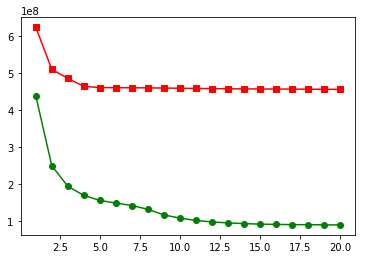

In [165]:
plt.plot(iteration,cost_list1,'s-',color = 'r', label="c1")
plt.plot(iteration,cost_list1_1,'o-',color = 'g', label="c2")

In [ ]:
plt.figure(figsize=(15,10),dpi=100)

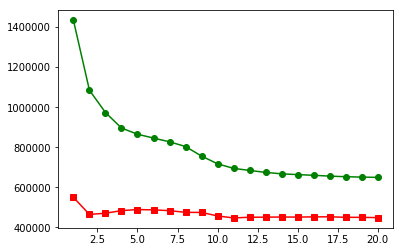

In [171]:
plt.plot(iteration,cost_list1_2,'s-',color = 'r', label="c1")
plt.plot(iteration,cost_list1_3,'o-',color = 'g', label="c2")

In [359]:
dict_plot = {"Round1":cost_list1,"Round2":cost_list1_1}

In [360]:
dict_df = DataFrame(dict_plot)

In [362]:
dict_df.to_csv('C:\\Users\\admin\\Desktop\\eu.csv')

In [363]:
dict_plot1 = {"Round1":cost_list1_2,"Round2":cost_list1_3}
dict_df_1 = DataFrame(dict_plot1)
dict_df_1.to_csv('C:\\Users\\admin\\Desktop\\ma.csv')

# table

# EU

In [352]:
em1 = []
ee1 = []
ec1.sort()
for c in ec1:
    ee1.append(c[1])
    em1.append(c[2])

In [353]:
em2 = []
ee2 = []
ec2.sort()
for c in ec2:
    ee2.append(c[1])
    em2.append(c[2])

# MA

In [354]:
me1 = []
mm1 = []
mc1.sort()
for c in mc1:
    me1.append(c[1])
    mm1.append(c[2])

In [355]:
me2 = []
mm2 = []
mc2.sort()
for c in mc2:
    me2.append(c[1])
    mm2.append(c[2])

In [348]:
from pandas.core.frame import DataFrame
mm2 = DataFrame(mm2)

In [349]:
mm2.to_csv('C:\\Users\\admin\\Desktop\\mm2.csv')

In [357]:
em1 = DataFrame(em1)
ee1 = DataFrame(ee1)
em2 = DataFrame(em2)
ee2 = DataFrame(ee2)
me1 = DataFrame(me1)
mm1 = DataFrame(mm1)
me2 = DataFrame(me2)
mm2 = DataFrame(mm2)

In [358]:
em1.to_csv('C:\\Users\\admin\\Desktop\\em1.csv')
ee1.to_csv('C:\\Users\\admin\\Desktop\\ee1.csv')
em2.to_csv('C:\\Users\\admin\\Desktop\\em2.csv')
ee2.to_csv('C:\\Users\\admin\\Desktop\\ee2.csv')
me1.to_csv('C:\\Users\\admin\\Desktop\\me1.csv')
mm1.to_csv('C:\\Users\\admin\\Desktop\\mm1.csv')
me2.to_csv('C:\\Users\\admin\\Desktop\\me2.csv')
mm2.to_csv('C:\\Users\\admin\\Desktop\\mm2.csv')